In [1]:
using CairoMakie, LinearAlgebra, Dierckx, Optim

In [10]:
parsCRRA = (;α = 0.33, # Capital share
         β = 0.9, # Discount factor
         γ = 2.0, # CRRA parameter
         δ = 0.1, # Depreciation rate
         A = 10.0, # TFP
         θ = 3.0, # Expanding grid parameter
         grid_size = 101, # number of gridpoints
         grid_min = 0.75, # minimum gridpoint (multiple of steady state capital stock)
         grid_max = 1.25, # maximum gridpoint (multiple of steady state capital stock)
         lb = 0.7, # lower bound for optimisation
         ub = 1.3, # upper bound for optimisation
         maxiter = 10000, # maximum number of iterations
         toler = 4e-7) # tolerance

(α = 0.33, β = 0.9, γ = 2.0, δ = 0.1, A = 10.0, θ = 3.0, grid_size = 101, grid_min = 0.75, grid_max = 1.25, lb = 0.7, ub = 1.3, maxiter = 10000, toler = 4.0e-7)

In [3]:
function utility(c, pars)
    if pars.γ == 1
        return log(c)
    else
        return (c^(1-pars.γ))/(1-pars.γ)
    end
end

function production(k, kp, pars)
    (;A, α, δ) = pars
    return A*k^α + (1.0-δ)*k - kp
end

function exp_grid(pars)
    (; θ, grid_min, grid_max, grid_size, A, α, β, δ) = pars
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α)) 
    grid = LinRange(0.0, 1.0, grid_size)
    grid = grid_min*Kss .+ (grid_max*Kss .- grid_min*Kss).*grid.^θ
    return grid
end

function interpV(grid, v)
    return Spline1D(grid, v, k=3, bc="extrapolate")
end

function optimise(grid, interp_v, policy, pars)
    (; grid_size, lb, ub, β, A, α, δ) = pars
    v_new = zeros(grid_size)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    for i in 1:grid_size
        obj(kp) = - (utility(production(grid[i], kp, pars), pars) + β * interp_v(kp))
        res = optimize(obj,Kss*lb,Kss*ub)
        policy[i] = res.minimizer
        v_new[i] = -res.minimum
    end
    return v_new, policy
end

optimise (generic function with 1 method)

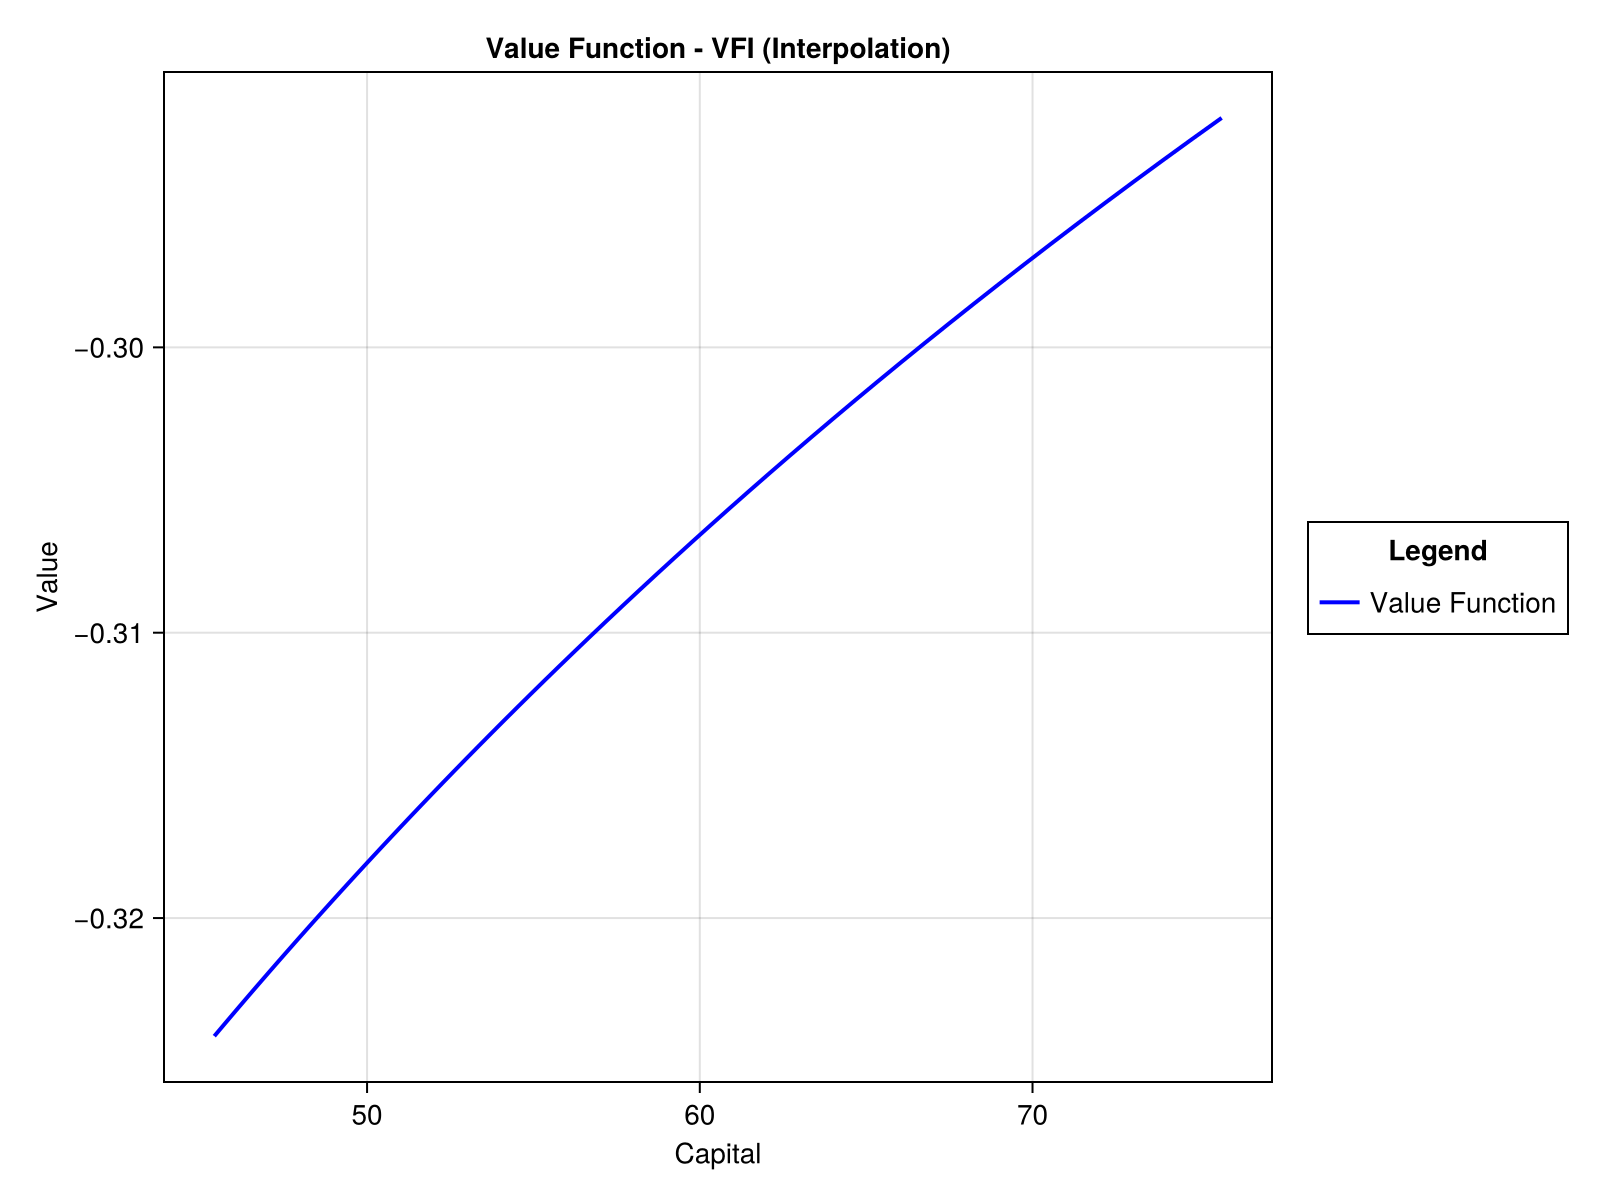

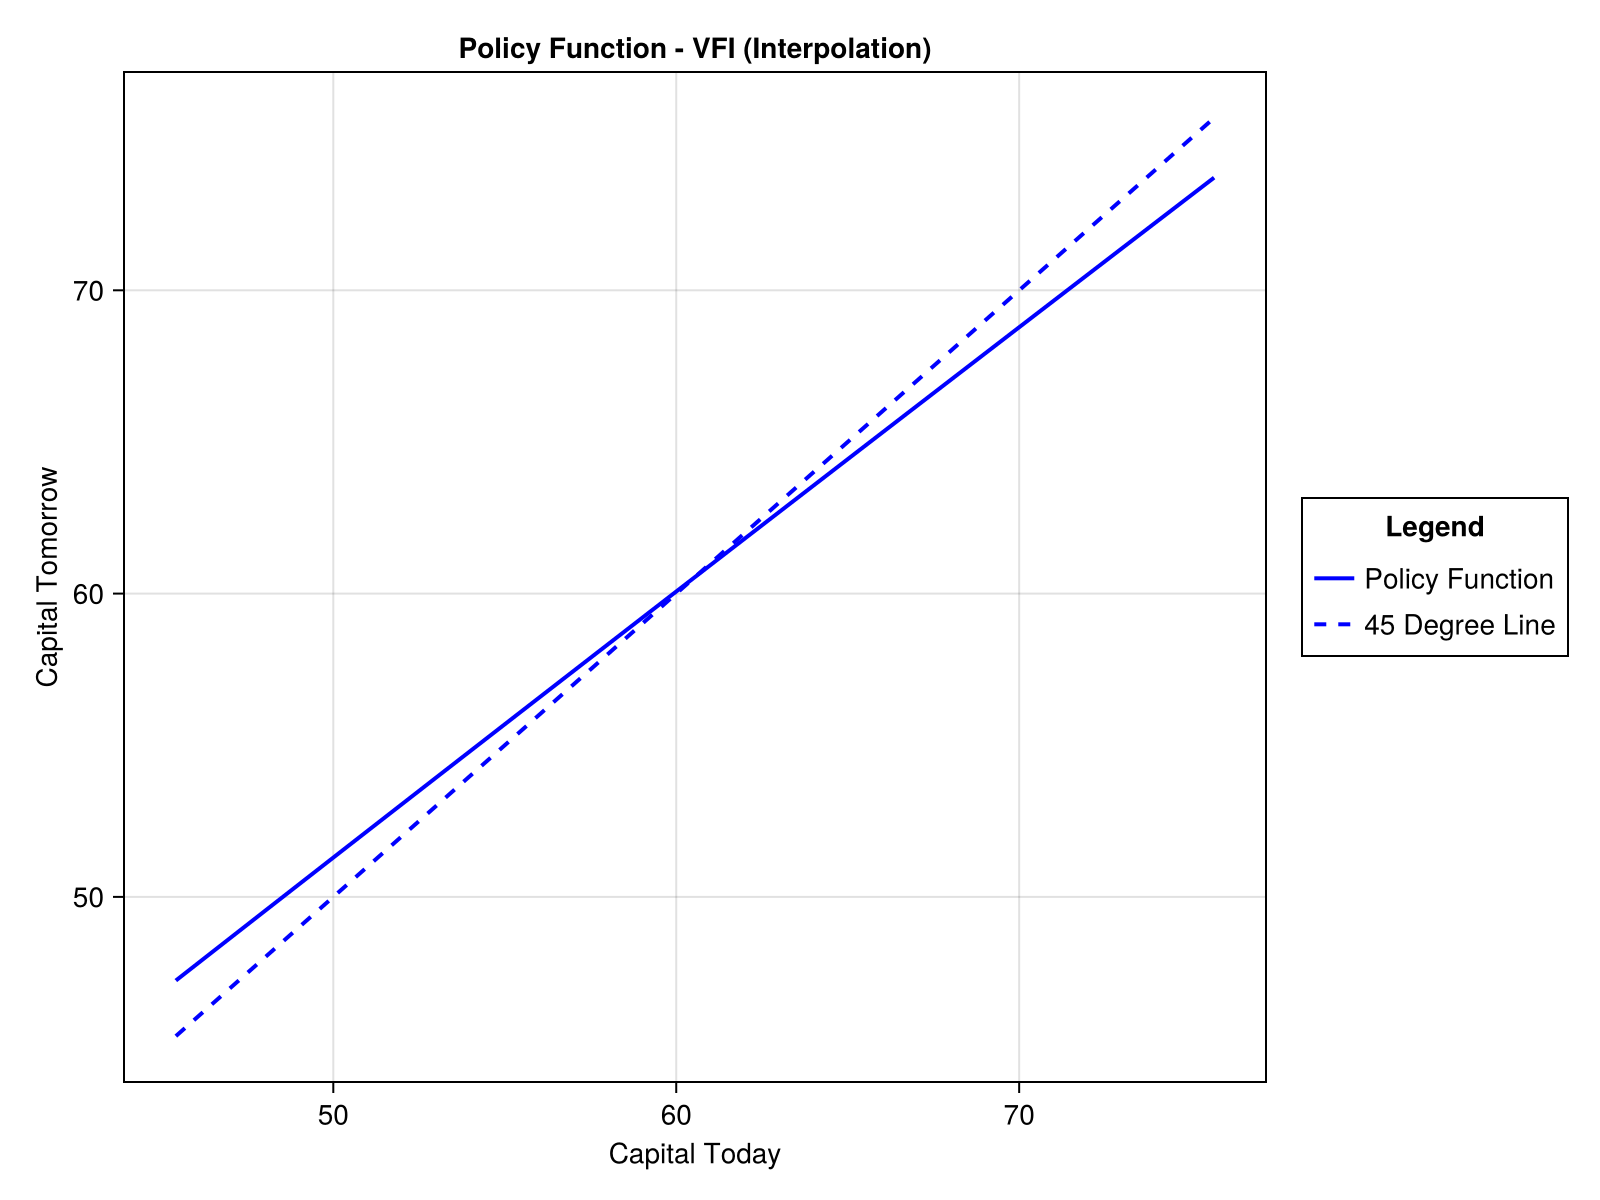

Iterating...
---------------------
Completed iteration 0 with error 0.0694086814279389

---------------------
Completed iteration 10 with error 0.11107879734371642

---------------------
Completed iteration 20 with error 0.11101860650937508

---------------------
Completed iteration 30 with error 0.11084619534206311

---------------------
Completed iteration 40 with error 0.11035470144638734

---------------------
Completed iteration 50 with error 0.10896898749725158

---------------------
Completed iteration 60 with error 0.10518111602831165

---------------------
Completed iteration 70 with error 0.09564583950733489

---------------------
Completed iteration 80 with error 0.07590950198218979

---------------------
Completed iteration 90 with error 0.04768782156572444

---------------------
Completed iteration 100 with error 0.017660837026626568

---------------------
Completed iteration 110 with error 0.005580252168777827

---------------------
Completed iteration 120 with error 0.00

(Float32[-0.32413626, -0.3241362, -0.3241359, -0.32413512, -0.32413355, -0.32413098, -0.32412717, -0.32412183, -0.32411474, -0.32410562  …  -0.2984853, -0.29778787, -0.2970831, -0.2963712, -0.29565227, -0.29492655, -0.29419422, -0.29345542, -0.29271036, -0.29195923], Float32[47.243164, 47.24319, 47.243378, 47.24389, 47.24488, 47.246513, 47.248955, 47.252357, 47.256886, 47.262703  …  67.23789, 67.89907, 68.574524, 69.26439, 69.96882, 70.68795, 71.42194, 72.170944, 72.93509, 73.71454])

In [11]:
function vfi(v, pars)
    (; α, β, δ, grid_size, maxiter, toler, A) = pars
    v_init = ones(grid_size)
    policy = similar(v)
    K = exp_grid(pars)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v = interpV(K, v_init)
        v_new, policy = optimise(K, v, policy, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % 10 == 0
            println("---------------------")
            println("Completed iteration $iter with error $error\n")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged after $iter iterations with error $error\n")
    println("--------------------")

    K = vec(Float32.(K))
    v_init = vec(Float32.(v_init))
    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Function - VFI (Interpolation)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, K, v_init, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    policy = vec(Float32.(policy))
    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Function - VFI (Interpolation)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, K, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, K, K, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)

    return v_init, policy
end

test_v = zeros(parsCRRA.grid_size)
@time begin
    v_out, policy_out = vfi(test_v, parsCRRA)
end

In [12]:
parsCES = (;α = 0.33, # Capital share
         β = 0.9, # Discount factor
         γ = 2.0, # CRRA parameter
         δ = 0.1, # Depreciation rate
         A = 10.0, # TFP
         θ = 3.0, # Expanding grid parameter
         grid_size = 101, # number of gridpoints
         grid_min = 0.75, # minimum gridpoint (multiple of steady state capital stock)
         grid_max = 1.25, # maximum gridpoint (multiple of steady state capital stock)
         lb = 0.7, # lower bound for optimisation
         ub = 1.3, # upper bound for optimisation
         maxiter = 10000, # maximum number of iterations
         toler = 4e-7) # tolerance

(α = 0.33, β = 0.9, γ = 2.0, δ = 0.1, A = 10.0, θ = 3.0, grid_size = 101, grid_min = 0.75, grid_max = 1.25, lb = 0.7, ub = 1.3, maxiter = 10000, toler = 4.0e-7)

In [16]:
function utility_EZ(c, pars)
    return (c^(1-pars.γ))
end

function interpV_EZ(grid, v)
    interp = Spline1D(grid, v, k=1, bc="extrapolate")
    transformed_interp(x) = interp(x)^(1.0-parsCES.γ)
    return transformed_interp
end

function optimise_EZ(grid, interp_v, policy, pars)
    (; grid_size, lb, ub, β, A, α, δ, γ) = pars
    v_new = zeros(grid_size)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    for i in 1:grid_size
        obj_EZ(kp) = - ( (1-β) * utility_EZ(production(grid[i], kp, pars), pars) + β * interp_v(kp))^(1.0/(1.0-γ))
        res = optimize(obj_EZ,Kss*lb,Kss*ub)
        policy[i] = res.minimizer
        v_new[i] = -res.minimum
    end
    return v_new, policy
end

optimise_EZ (generic function with 1 method)

Iterating...
---------------------
Completed iteration 0 with error 0.051810557595252126

---------------------
Completed iteration 100 with error 8.545769768177214e-5

--------------------
Converged after 152 iterations with error 3.9674338166924505e-7

--------------------
  1.178697 seconds (13.67 M allocations: 316.845 MiB, 1.59% gc time, 15.76% compilation time)


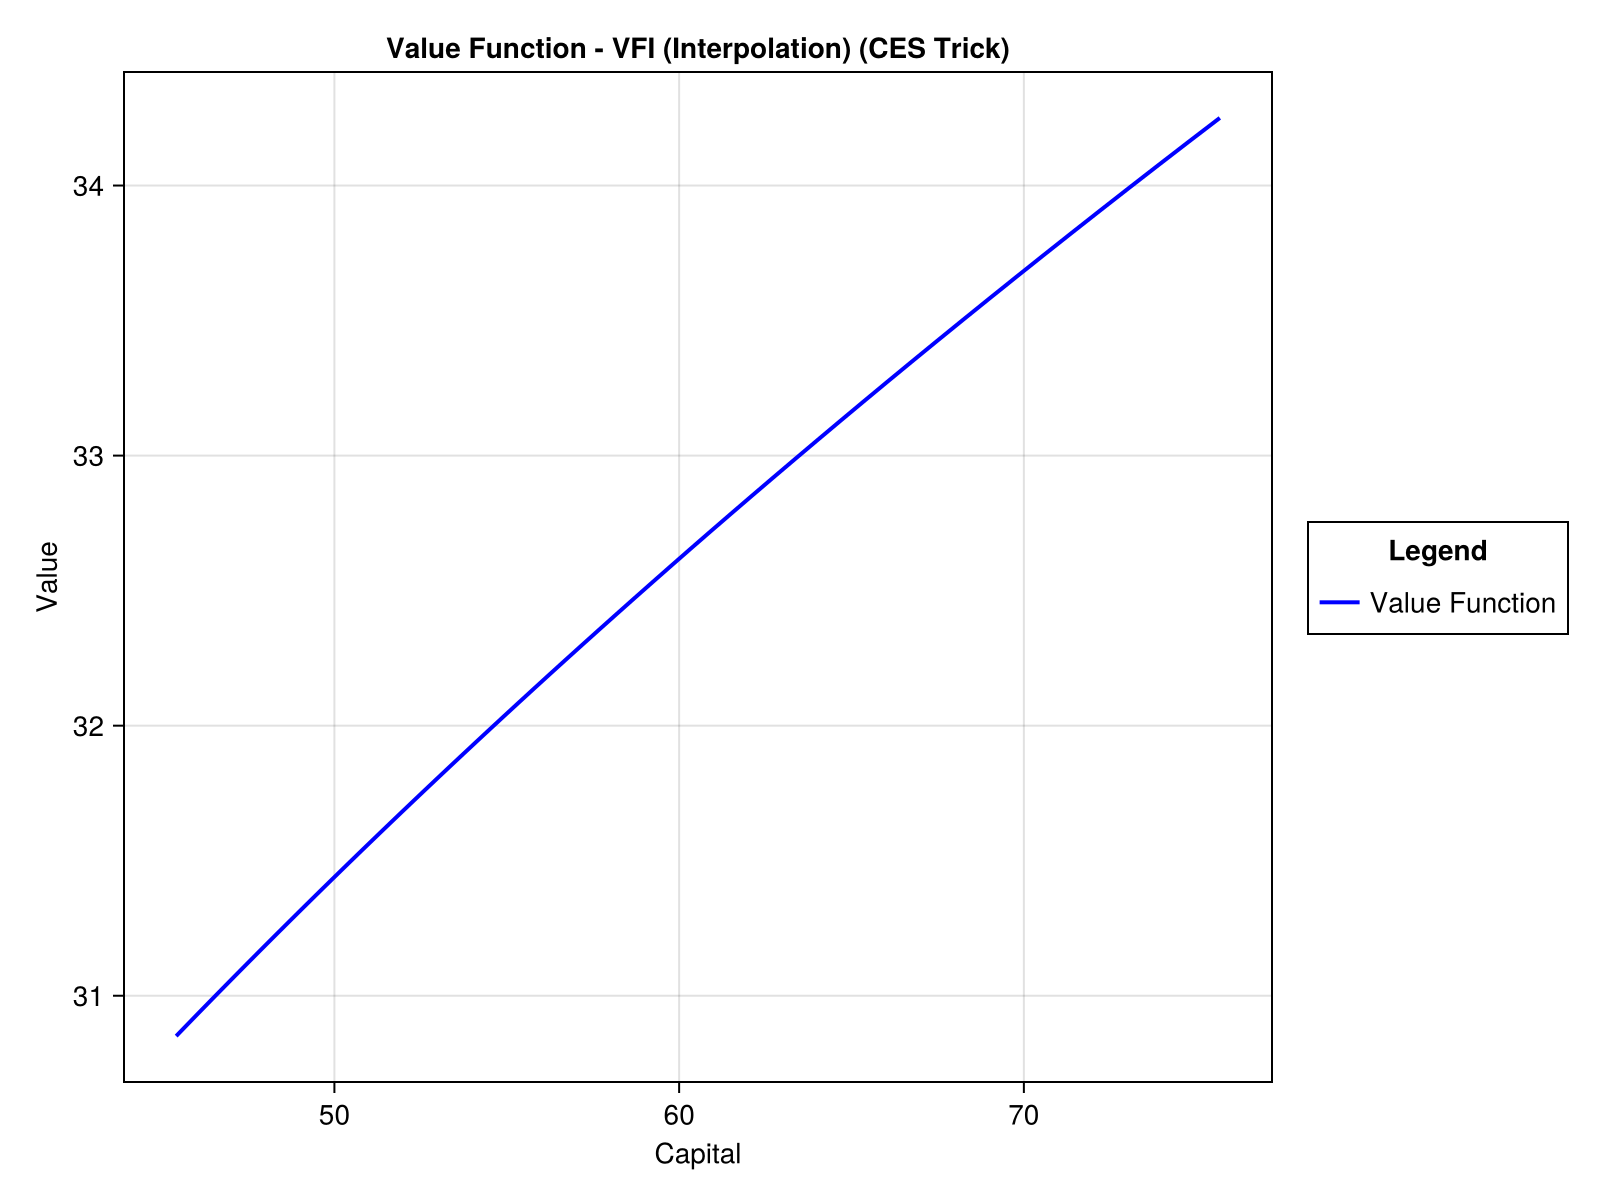

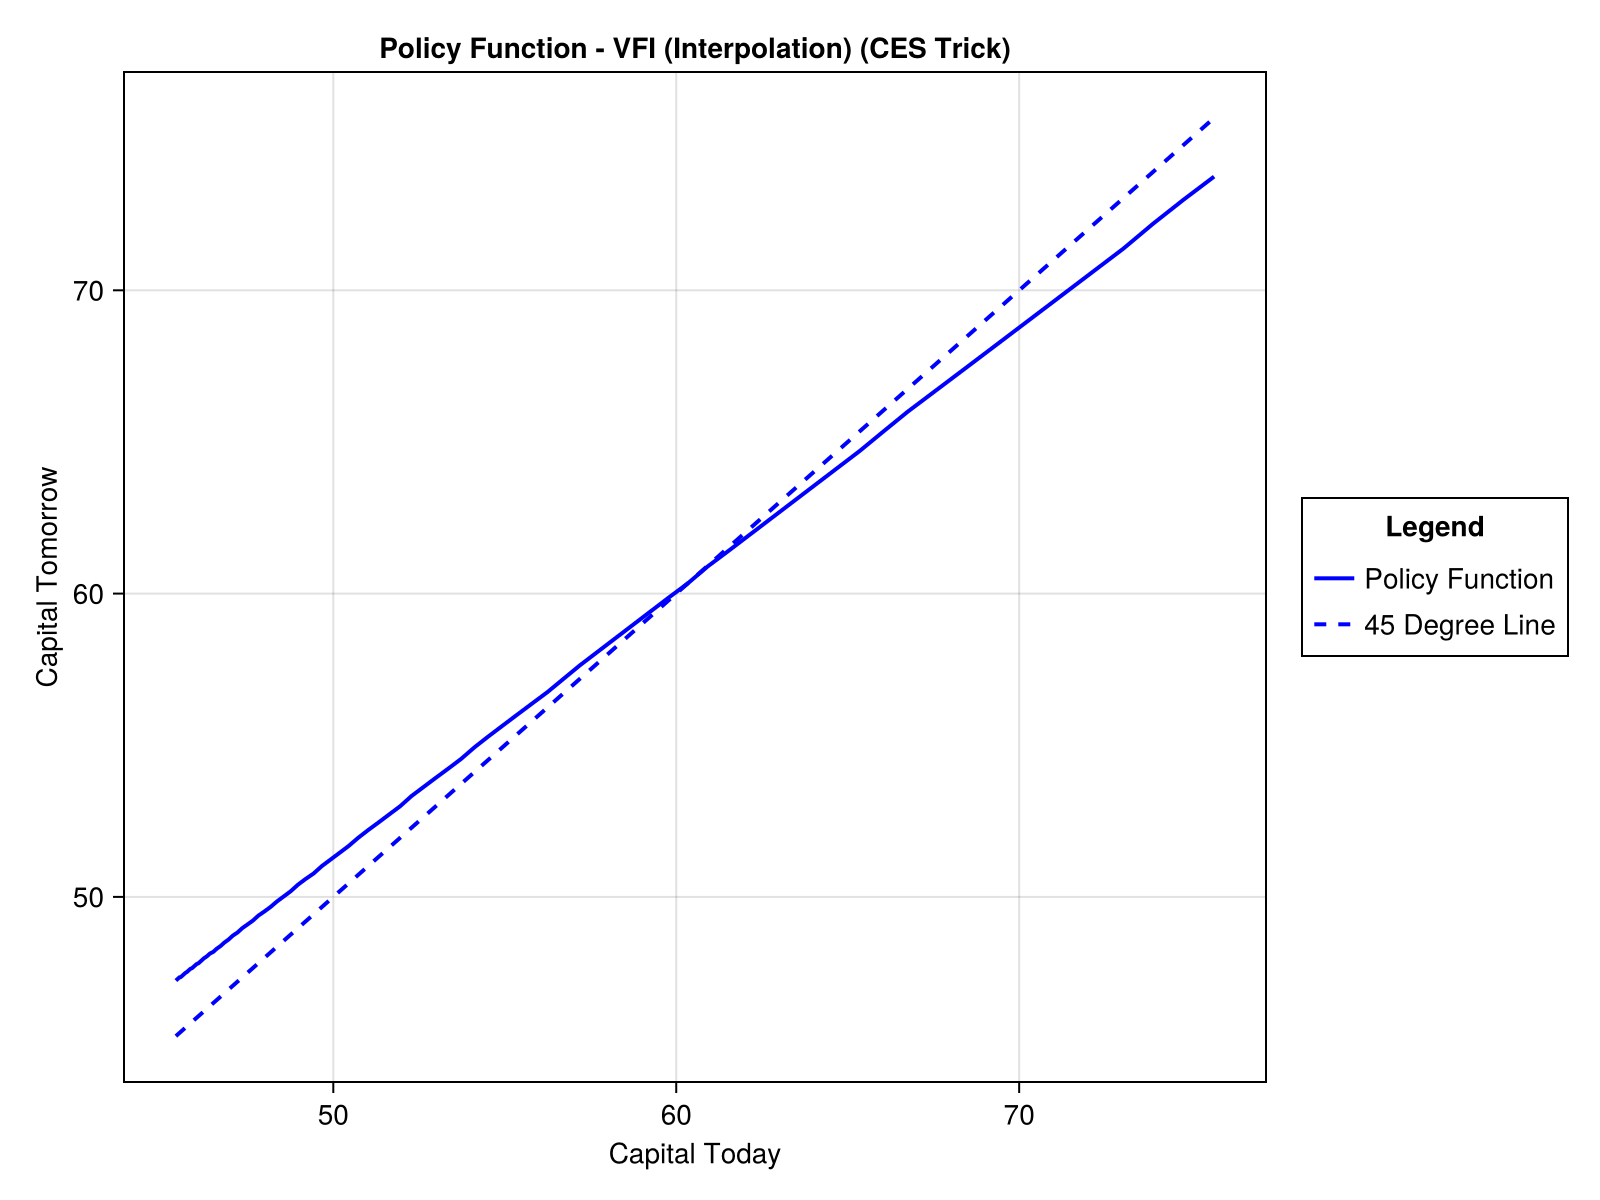

(Float32[30.850588, 30.850592, 30.850618, 30.850695, 30.850843, 30.851088, 30.851452, 30.85196, 30.852634, 30.853504  …  33.501606, 33.580044, 33.659687, 33.74053, 33.822567, 33.9058, 33.990215, 34.0758, 34.16253, 34.25041], Float32[47.241505, 47.241535, 47.241756, 47.242348, 47.243507, 47.24541, 47.248257, 47.252224, 47.257507, 47.26429  …  67.25241, 67.90196, 68.56675, 69.246605, 69.94144, 70.65125, 71.3761, 72.194496, 72.98023, 73.74885])

In [18]:
function vfi_EZ(v, pars)
    (; α, β, δ, grid_size, maxiter, toler, A) = pars
    v_init = ones(grid_size)
    v_new = similar(v)
    policy = similar(v)
    K = exp_grid(pars)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v = interpV_EZ(K, v_init)
        v_new, policy = optimise_EZ(K, v, policy, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % 100 == 0
            println("---------------------")
            println("Completed iteration $iter with error $error\n")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged after $iter iterations with error $error\n")
    println("--------------------")

    K = vec(Float32.(K))
    v_init = vec(Float32.(v_init))
    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Function - VFI (Interpolation) (CES Trick)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, K, v_init, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    policy = vec(Float32.(policy))
    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Function - VFI (Interpolation) (CES Trick)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, K, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, K, K, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)

    return v_init, policy
end

test_v = zeros(parsCES.grid_size)
@time begin
    v_EV, pol_EV = vfi_EZ(test_v, parsCES)
end